In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

#Load data from csv file
data = pd.read_csv("data1NormWithColNamesRowNames.csv")
data.head(10) 

data.set_index("Unnamed: 0", inplace = True)
data.index.name = None

X = data.iloc[:, data.columns != 'assigned_cluster'].values
#X=data.iloc[:,0:4915]
X = np.absolute(X)

y = data.iloc[:,data.columns == 'assigned_cluster'].values.ravel()

               

/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
classifier=xgb.XGBClassifier(use_label_encoder=False)

In [6]:
def precision_MC(y_true, y_pred):
    TP = np.diag(confusion_matrix(y_true, y_pred))
    FP = confusion_matrix(y_true, y_pred).sum(axis=1) - np.diag(confusion_matrix(y_true, y_pred))
    FP = FP.astype(float)
    TP = TP.astype(float)
    precision = TP/(TP+FP) * 100
    return precision

def recall_MC(y_true, y_pred):
    TP = np.diag(confusion_matrix(y_true, y_pred))
    FN = confusion_matrix(y_true, y_pred).sum(axis=0) - np.diag(confusion_matrix(y_true, y_pred))
    FN = FN.astype(float)
    TP = TP.astype(float)
    recall =  TP/(TP+FN) * 100
    return recall

def accuracy_MC(y_true, y_pred):
    FP = confusion_matrix(y_true, y_pred).sum(axis=1) - np.diag(confusion_matrix(y_true, y_pred))  
    FN = confusion_matrix(y_true, y_pred).sum(axis=0) - np.diag(confusion_matrix(y_true, y_pred))
    TP = np.diag(confusion_matrix(y_true, y_pred))
    TP = TP.astype(float)
    TN = confusion_matrix(y_true, y_pred).sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TN = TN.astype(float)
    accuracy = (TP+TN)/(TP+FP+FN+TN) * 100
    return accuracy

def npval_MC(y_true, y_pred): 
    FN = confusion_matrix(y_true, y_pred).sum(axis=0) - np.diag(confusion_matrix(y_true, y_pred))
    FN = FN.astype(float)
    TP = np.diag(confusion_matrix(y_true, y_pred))
    TP = TP.astype(float)
    FP = confusion_matrix(y_true, y_pred).sum(axis=1) - np.diag(confusion_matrix(y_true, y_pred)) 
    FP = FP.astype(float)
    TN = confusion_matrix(y_true, y_pred).sum() - (FP + FN + TP)
    TN = TN.astype(float)
    npv = TN/(TN+FN) * 100
    return npv

def specificity_MC(y_true, y_pred): 
    FP = confusion_matrix(y_true, y_pred).sum(axis=1) - np.diag(confusion_matrix(y_true, y_pred)) 
    FP = FP.astype(float)
    FN = confusion_matrix(y_true, y_pred).sum(axis=0) - np.diag(confusion_matrix(y_true, y_pred))
    FN = FN.astype(float)
    TP = np.diag(confusion_matrix(y_true, y_pred))
    TP = TP.astype(float)
    TN = confusion_matrix(y_true, y_pred).sum() - (FP + FN + TP)
    TN = TN.astype(float)
    spec = TN/(TN+FP)  * 100
    return spec


def plot_ROC_curve_MC(y_true, y_pred, FSName):
    n_classes = len(np.unique(y_true))
    y_true = label_binarize(y_true, classes=np.arange(n_classes))
    #y_pred = label_binarize(y_pred, classes=np.arange(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    # Plot all ROC curves
    plt.figure()
    #colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve of " + str(FSName))
    plt.legend(loc="lower right")
    path = "ROC_"+ str(FSName)
    plt.savefig(f'{path}.png')

#Bayesian Search
bayesian_search = BayesSearchCV(
        classifier,
        {
            'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            'max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             'min_child_weight' : [ 1, 3, 5, 7 ],
             'gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
            #'max_leaf_nodes':Integer(0,prior='log-uniform'),
            #'min_samples_leaf':Real(0.1,0.5,prior='uniform'),
            #'min_samples_split':Real(0.1,1,prior='uniform')
        },
        n_iter=50,scoring='accuracy',n_jobs = -1, verbose = 10,
        random_state=0, cv=10
    )
#grid_search = GridSearchCV(SVC(), tuned_params, cv=10, scoring='accuracy',n_jobs = -1, verbose = 10)
bayesian_search.fit(X, y)
bayesian_search.best_params_
print("")
print("Best Parameters Found")
print(bayesian_search.best_params_) 
clf = xgb.XGBClassifier(learning_rate = bayesian_search.best_params_['learning_rate'], max_depth = bayesian_search.best_params_['max_depth'], min_child_weight= bayesian_search.best_params_['min_child_weight'],
      gamma= bayesian_search.best_params_['gamma'], colsample_bytree= bayesian_search.best_params_['colsample_bytree'], use_label_encoder=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
X_train.shape
X_test.shape 
Xgboost_accuracy = accuracy_score(y_test, y_pred)
print("Xgboost Accuracy")
print(Xgboost_accuracy) #0.9585492227979274, 0.6621621621621622

perf_cols = ["Cell Type", "Accuracy%","Precision%","Recall%","Negative Predictive Value%","Specificity%","F1-score%"]
perf_anova  = pd.DataFrame(columns = perf_cols)
label = np.unique(y.tolist())
class_lbl = [int(i) for i in label] 
class_lbl = ['CellType ' + str(s) for s in class_lbl]

pre_chi2 = precision_MC(y_test,y_pred)
rec_chi2 = recall_MC(y_test,y_pred)
acc_chi2 = accuracy_MC(y_test,y_pred)
npv_chi2 = npval_MC(y_test,y_pred)
spe_chi2 = specificity_MC(y_test,y_pred)
f1_chi2 = 2* (pre_chi2 * rec_chi2)/(pre_chi2 + rec_chi2)

print("XGBoost MultiClass")
print(pre_chi2)
print(rec_chi2)
print(acc_chi2)
print(npv_chi2)
print(spe_chi2)
print(f1_chi2)

perf_chi2['Cell Type'] = class_lbl
perf_chi2['Precision%'] = pre_chi2.tolist()
perf_chi2['Accuracy%'] =  acc_chi2.tolist()
perf_chi2['Recall%']  = rec_chi2.tolist()
perf_chi2['Negative Predictive Value%'] = npv_chi2.tolist()
perf_chi2['Specificity%'] = spe_chi2.tolist()
perf_chi2['F1-score%'] = f1_chi2.tolist()

perf_chi2.to_csv('xgboosPerformanceMetrics.csv', index = False)

#Plot ROC curve for OneVsRest + Chi2
#y_score_chi2 = classifier.fit(X_train_chi2, y_train_chi2).decision_function(X_test_chi2)

n_classes = len(np.unique(y_test))
y_pred_chi = label_binarize(y_pred, classes=np.arange(n_classes))

plot_ROC_curve_MC(y_test, y_pred_chi, "Chi2")


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pand

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 4/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:30:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/10; 1/1] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7;, score=0.984 total time= 2.5min
[CV 8/10; 1/1] START colsample_bytree=0.4, gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=3
[14:33:53] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. 

[CV 1/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:30:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10; 1/1] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7;, score=0.984 total time= 2.6min
[CV 6/10; 1/1] START colsample_bytree=0.4, gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=3
[14:33:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. 

[CV 6/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:30:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 6/10; 1/1] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7;, score=0.959 total time= 2.5min
[CV 9/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:33:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.

/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pand

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 3/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:30:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10; 1/1] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7;, score=0.974 total time= 2.5min
[CV 10/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:33:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 7/10; 1/1] START colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7
[14:30:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 7/10; 1/1] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=7;, score=0.948 total time= 2.5min
[CV 1/10; 1/1] START colsample_bytree=0.4, gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=3
[14:33:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 4/10; 1/1] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1
[15:05:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/10; 1/1] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1;, score=0.990 total time= 2.9min
[CV 4/10; 1/1] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=3
[15:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 6/10; 1/1] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1
[15:05:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 6/10; 1/1] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1;, score=0.964 total time= 2.8min
[CV 3/10; 1/1] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=3
[15:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 5/10; 1/1] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1
[15:05:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/10; 1/1] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1;, score=0.969 total time= 2.9min
[CV 8/10; 1/1] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=3
[15:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 8/10; 1/1] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1
[15:05:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 8/10; 1/1] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1;, score=0.969 total time= 2.9min
[CV 5/10; 1/1] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=3
[15:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[CV 7/10; 1/1] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1
[15:05:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 7/10; 1/1] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=3, min_child_weight=1;, score=0.964 total time= 2.9min
[CV 6/10; 1/1] START colsample_bytree=0.3, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=3
[15:09:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/Yash/opt/anaconda3/envs/Om_sai_ram/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


[17:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Best Parameters Found
OrderedDict([('colsample_bytree', 0.5), ('gamma', 0.2), ('learning_rate', 0.15), ('max_depth', 10), ('min_child_weight', 3)])
[17:53:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgboost Accuracy


NameError: name 'chi2_accuracy' is not defined

In [7]:
print(Xgboost_accuracy)

0.9740932642487047


/var/folders/fh/mtkq58kd5ks3szv1j095_fbc0000gp/T/ipykernel_80203/3533521258.py:14: RuntimeWarning: invalid value encountered in true_divide
  recall =  TP/(TP+FN) * 100


XGBoost MultiClass
[ 96.875      100.          90.625       92.85714286  94.44444444
 100.         100.          90.47619048  97.43589744 100.
  75.         100.         100.           0.        ]
[ 96.875       96.67896679  98.30508475 100.          97.14285714
  97.26027397 100.         100.         100.         100.
 100.         100.          66.66666667          nan]
[ 99.65457686  98.44559585  98.791019    99.82728843  99.48186528
  99.65457686 100.          99.65457686  99.82728843 100.
  99.82728843 100.          99.82728843  99.82728843]
[ 99.81718464  97.16088328  99.80582524 100.          99.81583794
  99.60629921 100.         100.         100.         100.
 100.         100.          99.82668977 100.        ]
[ 99.81718464 100.          98.84615385  99.82332155  99.63235294
 100.         100.          99.64285714  99.81515712 100.
  99.82638889 100.         100.          99.82728843]
[ 96.875       98.31144465  94.30894309  96.2962963   95.77464789
  98.61111111 100.       

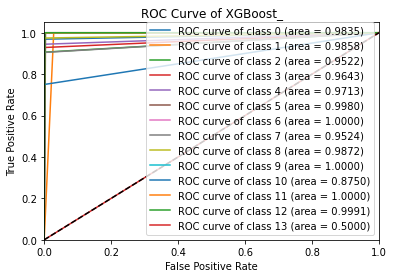

In [14]:
perf_cols = ["Cell Type", "Accuracy%","Precision%","Recall%","Negative Predictive Value%","Specificity%","F1-score%"]
perf  = pd.DataFrame(columns = perf_cols)
label = np.unique(y.tolist())
class_lbl = [int(i) for i in label] 
class_lbl = ['CellType ' + str(s) for s in class_lbl]

pre_chi2 = precision_MC(y_test,y_pred)
rec_chi2 = recall_MC(y_test,y_pred)
acc_chi2 = accuracy_MC(y_test,y_pred)
npv_chi2 = npval_MC(y_test,y_pred)
spe_chi2 = specificity_MC(y_test,y_pred)
f1_chi2 = 2* (pre_chi2 * rec_chi2)/(pre_chi2 + rec_chi2)

print("XGBoost MultiClass")
print(pre_chi2)
print(rec_chi2)
print(acc_chi2)
print(npv_chi2)
print(spe_chi2)
print(f1_chi2)

perf['Cell Type'] = class_lbl
perf['Precision%'] = pre_chi2.tolist()
perf['Accuracy%'] =  acc_chi2.tolist()
perf['Recall%']  = rec_chi2.tolist()
perf['Negative Predictive Value%'] = npv_chi2.tolist()
perf['Specificity%'] = spe_chi2.tolist()
perf['F1-score%'] = f1_chi2.tolist()

perf.to_csv('XgboostPerformanceMetrics.csv', index = False)

#Plot ROC curve for OneVsRest + Chi2
#y_score_chi2 = classifier.fit(X_train_chi2, y_train_chi2).decision_function(X_test_chi2)

n_classes = len(np.unique(y_test))
y_pred_chi = label_binarize(y_pred, classes=np.arange(n_classes))

plot_ROC_curve_MC(y_test, y_pred_chi, "XGBoost_")
